# based on `pytorch/example/reinforcement_learning/reinforce.py`

In [1]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

In [361]:
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')

In [3]:
obs = env.reset()

In [4]:
# env.render()

In [5]:
obs

array([ 0.01994168,  0.01506877, -0.01345914,  0.04869519])

In [6]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)
    
    def select_action(self, obs):
        state = torch.from_numpy(obs).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        m = Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.data[0]
    
    def get_policy_loss_and_clear(self):
        pass

In [7]:
policy_network = PolicyNetwork()

In [8]:
policy_network.select_action(obs)

1

In [9]:
policy_network.saved_log_probs

[Variable containing:
 -0.7209
 [torch.FloatTensor of size 1]]

In [10]:
inputs = Variable(torch.from_numpy(obs).float().unsqueeze(0))

In [11]:
proba = policy_network(inputs)
proba

Variable containing:
 0.5137  0.4863
[torch.FloatTensor of size 1x2]

In [12]:
policy_network.rewards

[]

In [13]:
proba

Variable containing:
 0.5137  0.4863
[torch.FloatTensor of size 1x2]

In [14]:
m = Categorical(proba)

In [15]:
m

In [390]:
m.sample()

Variable containing:
 0
[torch.LongTensor of size 1]

In [397]:
m.probs.size(1)

2

In [399]:
proba.size(1)

2

In [16]:
?m.sample

In [17]:
??m.sample_n

In [18]:
m.sample(sample_shape=(10,10))

Variable containing:
(0 ,.,.) = 
   0
   0
   1
   1
   0
   1
   0
   1
   0
   1

(1 ,.,.) = 
   0
   1
   0
   0
   0
   0
   1
   1
   0
   0

(2 ,.,.) = 
   0
   0
   0
   0
   0
   0
   1
   1
   0
   1

(3 ,.,.) = 
   1
   1
   0
   1
   1
   1
   0
   0
   0
   1

(4 ,.,.) = 
   0
   1
   0
   1
   1
   1
   1
   1
   0
   1

(5 ,.,.) = 
   1
   1
   1
   1
   1
   0
   0
   1
   1
   0

(6 ,.,.) = 
   0
   0
   1
   1
   0
   1
   0
   1
   0
   0

(7 ,.,.) = 
   0
   0
   0
   0
   1
   0
   0
   1
   1
   1

(8 ,.,.) = 
   1
   0
   0
   0
   0
   1
   0
   0
   1
   1

(9 ,.,.) = 
   1
   1
   1
   1
   0
   1
   0
   0
   0
   0
[torch.LongTensor of size 10x10x1]

In [19]:
action = m.sample()
action.size()

torch.Size([1])

In [33]:
action

Variable containing:
 1
[torch.LongTensor of size 1]

In [20]:
m.log_prob(action)

Variable containing:
-0.7209
[torch.FloatTensor of size 1]

In [32]:
m.log_prob(0)

ValueError: The value argument to log_prob must be a Tensor or Variable instance.

In [21]:
?m.log_prob

In [22]:
lst = [2,3,4,5,5]

In [23]:
del lst[:]

In [24]:
lst

[]

In [25]:
from itertools import count

In [26]:
?count

In [27]:
for cnt in count(10):
    if cnt >50:
        break
    print(cnt)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [28]:
obs, reward, done, _ = env.step(env.action_space.sample())

In [29]:
obs

array([ 0.02024306, -0.17985763, -0.01248523,  0.33710144])

In [30]:
reward

1.0

In [31]:
done

False

In [320]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)
    
    def select_action(self, obs):
        state = torch.from_numpy(obs).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        m = Categorical(probs)
        action = m.sample()
        return action.data[0],m.log_prob(action)
    
#     def get_policy_loss_and_clear(self, rewards, log_probs, gamma=0.99, eps=1.e-6):
#         pass

In [321]:
network = PolicyNetwork()

In [322]:
# network.zero_grad()
network.affine1.weight.grad

In [323]:
rewards = []
log_probs = []

for episode in range(10):
    obs = env.reset()
    for played_turn in count():
        action, log_prob = network.select_action(obs)
        obs, reward, done, _ = env.step(action)
        log_probs.append(log_prob)
        rewards.append(reward)
        if done or (played_turn>10000):
            break

In [324]:
len(rewards)

206

In [325]:
len(log_probs)

206

In [326]:
def get_normalized_rewards(rewards, gamma, eps):
    acc = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        acc.append(R)
    ret = Variable(torch.Tensor(acc[::-1]),requires_grad=False)
    ret = (ret - ret.mean()) / (ret.std()+eps)
    return ret


def get_policy_loss(log_probs,rewards, gamma,eps):
#     rewards_v = get_normalized_rewards(rewards, gamma, eps).data
#     ret = 0
#     for r, lp in zip(rewards_v,log_probs):
#         ret+=r*lp
#     return -ret
    
#     ''''''
    log_probs_v = torch.cat(log_probs)
#     return log_probs_v.sum()
    rewards_v = get_normalized_rewards(rewards, gamma, eps)
    del log_probs[:]
    del rewards[:]
    return -log_probs_v.dot(rewards_v)
#     policy_grads = log_probs_v*rewards_v

#     return -policy_grads.sum()

In [327]:
# ?torch.dot

In [328]:
rewards_v = get_normalized_rewards(rewards,0.99,1.e-6)

In [329]:
rewards_v

Variable containing:
 1.2076
 1.2024
 1.1971
 1.1917
 1.1864
 1.1809
 1.1754
 1.1698
 1.1642
 1.1585
 1.1528
 1.1470
 1.1412
 1.1353
 1.1293
 1.1233
 1.1172
 1.1110
 1.1048
 1.0985
 1.0922
 1.0858
 1.0793
 1.0728
 1.0662
 1.0595
 1.0528
 1.0460
 1.0391
 1.0322
 1.0252
 1.0181
 1.0110
 1.0037
 0.9964
 0.9891
 0.9816
 0.9741
 0.9665
 0.9588
 0.9511
 0.9433
 0.9353
 0.9274
 0.9193
 0.9111
 0.9029
 0.8946
 0.8862
 0.8777
 0.8691
 0.8605
 0.8517
 0.8429
 0.8340
 0.8250
 0.8159
 0.8067
 0.7974
 0.7880
 0.7785
 0.7690
 0.7593
 0.7495
 0.7397
 0.7297
 0.7197
 0.7095
 0.6992
 0.6888
 0.6784
 0.6678
 0.6571
 0.6463
 0.6354
 0.6244
 0.6132
 0.6020
 0.5907
 0.5792
 0.5676
 0.5559
 0.5441
 0.5321
 0.5201
 0.5079
 0.4956
 0.4832
 0.4706
 0.4579
 0.4451
 0.4322
 0.4191
 0.4059
 0.3926
 0.3791
 0.3655
 0.3518
 0.3379
 0.3239
 0.3097
 0.2954
 0.2809
 0.2663
 0.2516
 0.2367
 0.2217
 0.2065
 0.1911
 0.1756
 0.1599
 0.1441
 0.1281
 0.1120
 0.0957
 0.0792
 0.0626
 0.0458
 0.0288
 0.0117
-0.0056
-0.0231
-0.

In [330]:
torch.cat(log_probs)*rewards_v

Variable containing:
-0.8088
-0.8452
-0.8567
-0.8850
-0.7282
-0.7641
-0.8389
-0.8670
-0.9074
-0.6790
-0.7061
-0.8537
-0.8949
-0.9357
-0.6243
-0.6390
-0.6672
-0.8511
-0.6478
-0.8566
-0.9065
-0.9521
-0.9877
-0.7668
-0.6951
-0.7134
-0.7338
-0.7054
-0.7219
-0.7337
-0.6784
-0.6903
-0.6972
-0.6827
-0.6972
-0.6661
-0.6901
-0.6966
-0.6988
-0.6975
-0.6154
-0.6200
-0.6683
-0.5984
-0.6163
-0.6231
-0.6167
-0.6293
-0.6377
-0.6583
-0.5283
-0.5482
-0.5658
-0.5724
-0.5823
-0.5854
-0.5412
-0.5451
-0.5563
-0.5310
-0.5447
-0.5167
-0.5188
-0.5124
-0.5029
-0.5019
-0.5103
-0.5108
-0.5076
-0.4513
-0.4923
-0.4772
-0.4268
-0.4615
-0.4687
-0.3850
-0.4522
-0.3712
-0.3839
-0.3890
-0.3888
-0.3792
-0.3818
-0.3575
-0.3649
-0.3414
-0.3474
-0.3450
-0.3469
-0.2825
-0.3279
-0.2668
-0.3090
-0.3151
-0.3205
-0.2117
-0.3011
-0.3019
-0.3013
-0.2997
-0.2984
-0.1969
-0.1986
-0.1922
-0.1893
-0.1872
-0.1836
-0.1136
-0.1601
-0.1530
-0.0829
-0.1279
-0.1185
-0.0798
-0.0705
-0.0614
-0.0506
-0.0260
-0.0169
-0.0091
 0.0046
 0.0198
 0.

In [331]:
pl = get_policy_loss(log_probs,rewards,0.99,1.e-6)
pl

Variable containing:
-1.2576
[torch.FloatTensor of size 1]

In [332]:
pl.backward()

In [333]:
pl.grad

In [334]:
log_probs

[]

In [335]:
network.affine1.weight.grad

Variable containing:
-0.0005  0.0020  0.0013 -0.0002
-0.0003  0.1329  0.0028 -0.1551
 0.0148  0.0169 -0.0070 -0.0263
 0.0383 -0.4525 -0.0130  0.5483
 0.0025 -0.0340 -0.0007  0.0415
-0.0114  0.1294  0.0059 -0.1536
 0.0049 -0.2651 -0.0006  0.3337
-0.0192  0.2193  0.0100 -0.2601
 0.0000  0.0000  0.0000  0.0000
 0.0242 -0.3767 -0.0058  0.4686
 0.0000  0.0000  0.0000  0.0000
 0.0350 -0.0455 -0.0083  0.0641
-0.0004 -0.0344 -0.0030  0.0276
-0.0006  0.2898  0.0023 -0.3531
-0.0035  0.0066  0.0031 -0.0055
 0.0074  0.0472 -0.0120 -0.0989
-0.0494  0.0855  0.0159 -0.1108
-0.0028  0.3335  0.0098 -0.3885
-0.0049  0.0051  0.0002 -0.0045
-0.0001  0.3082 -0.0018 -0.3856
-0.0012 -0.0097  0.0025  0.0190
 0.0070 -0.1249 -0.0016  0.1563
-0.0009 -0.0438  0.0015  0.0571
 0.0208 -0.3142 -0.0064  0.3926
 0.0234 -0.2664 -0.0121  0.3160
-0.0049  0.0555  0.0025 -0.0658
 0.0058 -0.0664 -0.0030  0.0787
 0.0000  0.0000  0.0000  0.0000
-0.0079  0.0898  0.0041 -0.1065
 0.0426 -0.4863 -0.0221  0.5768
-0.0215  0.2456  0.

In [381]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)


class PolicyGradient:
    
    def __init__(self, model, gamma=0.99, eps=1.e-6, running_gamma=0.99):
        self.model = model
        self.gamma = gamma
        self.eps = eps
        self.log_probs = []
        self.rewards = []
        self.total_rewards = []
        self.running_reward = 0
        self.running_gamma = running_gamma
        
    def select_action(self,obs):
        self.model.train(True)
        action, log_prob = select_action(obs, self.model)
        self.log_probs.append(log_prob)
        return action
    
    def get_loss_and_clear(self):
        total_reward = sum(self.rewards)
        self.total_rewards.append(total_reward)
        self.running_reward = self.running_gamma*self.running_reward+(1-self.running_gamma)*total_reward
        policy_loss = get_policy_loss(self.log_probs, self.rewards, self.gamma, self.eps)
        del self.log_probs[:]
        del self.rewards[:]
        return policy_loss
    
    def take_action(self, action, env, render=False):
        obs, reward, done, info = env.step(action)
        self.rewards.append(reward)
        if render:
            env.render()
        return obs, reward, done, info
    
    def greedy_policy(self, obs):
        self.model.train(False)
        state = torch.from_numpy(obs).float().unsqueeze(0)
        prob = self.model(Variable(state))
        max_prob, action = prob.max(dim=1)
        return action.data[0]
    
    
def select_action(obs, model):
    state = torch.from_numpy(obs).float().unsqueeze(0)
    probs = model(Variable(state))
    m = Categorical(probs)
    action = m.sample()
    return action.data[0],m.log_prob(action)
    
def get_normalized_rewards(rewards, gamma, eps):
    acc = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        acc.append(R)
    ret = Variable(torch.Tensor(acc[::-1]),requires_grad=False)
    ret = (ret - ret.mean()) / (ret.std()+eps)
    return ret


def get_policy_loss(log_probs,rewards, gamma,eps):
    log_probs_v = torch.cat(log_probs)
    rewards_v = get_normalized_rewards(rewards, gamma, eps)
    return -log_probs_v.dot(rewards_v)

In [382]:
net = Network()
optimizer = optim.Adam(net.parameters(), lr=1e-2)
trainer = PolicyGradient(net)

In [383]:
env = gym.make('CartPole-v1')

In [384]:
obs = env.reset()

In [387]:
trainer.greedy_policy(obs)

0

0 37.0 0.37000000000000033
1 16.0 0.5263000000000004
2 29.0 0.8110370000000007
3 29.0 1.092926630000001
4 36.0 1.4419973637000012
5 11.0 1.5375773900630012
6 20.0 1.7222016161623714
7 107.0 2.7749796000007487
8 21.0 2.9572298040007414
9 19.0 3.117657505960734
10 13.0 3.2164809309011266
11 22.0 3.4043161215921156
12 59.0 3.9602729603761953
13 21.0 4.1306702307724334
14 106.0 5.1493635284647095
15 61.0 5.707869893180063
16 47.0 6.1207911942482625
17 31.0 6.36958328230578
18 67.0 6.975887449482723
19 55.0 7.456128574987897
20 37.0 7.751567289238018
21 66.0 8.334051616345638
22 80.0 9.050711100182182
23 37.0 9.330203989180362
24 106.0 10.296901949288559
25 80.0 10.993932929795674
26 87.0 11.753993600497719
27 43.0 12.066453664492741
28 39.0 12.335789127847814
29 40.0 12.612431236569336
30 76.0 13.246306924203644
31 54.0 13.653843854961607
32 72.0 14.237305416411992
33 73.0 14.824932362247873
34 49.0 15.166683038625395
35 206.0 17.07501620823914
36 104.0 17.94426604615675
37 43.0 18.1948233

KeyboardInterrupt: 

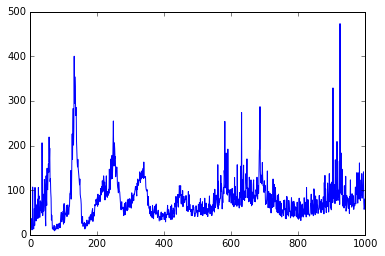

In [388]:
for episode in range(1000):
    obs = env.reset()
    total_reward = 0
    for _ in range(10000): # not exceed 10000 episodes
        action = trainer.select_action(obs)
        obs, reward, done, _ = trainer.take_action(action, env, render=False)
        total_reward+=reward
        if done:
             break
    policy_loss = trainer.get_loss_and_clear()
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
    running_reward = trainer.running_reward
    print(episode, total_reward,running_reward)
    if running_reward>env.spec.reward_threshold:
        break
print("Finished: %s" %trainer.running_reward)
plt.plot(trainer.total_rewards)
for i in range(100):
    obs = env.reset()
    total_reward=0
    for _ in range(10000): # not exceed 10000 episodes
        action = trainer.greedy_policy(obs)
        obs, reward, done, _ = env.step(action)
        env.render()
        total_reward+=reward
        if done:
             break
    print("Encore: %s"%total_reward)

0 83.0 86.55690383113057
1 83.0 86.52133479281926
2 135.0 87.00612144489106
3 123.0 87.36606023044216
4 94.0 87.43239962813773
5 73.0 87.28807563185636
6 97.0 87.38519487553779
7 63.0 87.14134292678241
8 234.0 88.6099294975146
9 69.0 88.41383020253944
10 67.0 88.19969190051405
11 59.0 87.90769498150891
12 76.0 87.78861803169383
13 116.0 88.07073185137689
14 268.0 89.87002453286313
15 162.0 90.5913242875345
16 73.0 90.41541104465917
17 58.0 90.09125693421257
18 78.0 89.97034436487044
19 136.0 90.43064092122174
20 75.0 90.27633451200951
21 132.0 90.69357116688943
22 92.0 90.70663545522054
23 143.0 91.22956910066834
24 47.0 90.78727340966165
25 70.0 90.57940067556504
26 67.0 90.34360666880939
27 87.0 90.31017060212129
28 64.0 90.04706889610007
29 56.0 89.70659820713907
30 55.0 89.35953222506767
31 129.0 89.755936902817
32 63.0 89.48837753378882
33 106.0 89.65349375845094
34 82.0 89.57695882086644
35 68.0 89.36118923265778
36 86.0 89.3275773403312
37 73.0 89.16430156692789
38 97.0 89.24265

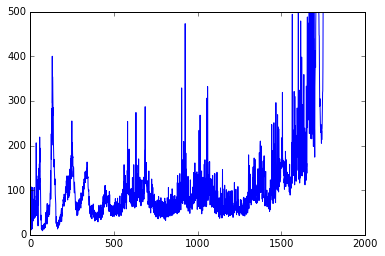

In [389]:
for episode in range(10000):
    obs = env.reset()
    total_reward = 0
    for _ in range(10000): # not exceed 10000 episodes
        action = trainer.select_action(obs)
        obs, reward, done, _ = trainer.take_action(action, env, render=False)
        total_reward+=reward
        if done:
             break
    policy_loss = trainer.get_loss_and_clear()
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
    running_reward = trainer.running_reward
    print(episode, total_reward,running_reward)
    if running_reward>env.spec.reward_threshold:
        break
print("Finished: %s@%s" %(trainer.running_reward,episode))
plt.plot(trainer.total_rewards)
for i in range(100):
    obs = env.reset()
    total_reward=0
    for _ in range(10000): # not exceed 10000 episodes
        action = trainer.greedy_policy(obs)
        obs, reward, done, _ = env.step(action)
        env.render()
        total_reward+=reward
        if done:
             break
    print("Encore: %s"%total_reward)

In [350]:
pl = trainer.get_loss_and_clear()

RuntimeError: seq can't be empty

In [347]:
pl

Variable containing:
 2.3070
[torch.FloatTensor of size 1]

In [348]:
pl.backward()

In [349]:
net.affine1.weight.grad

Variable containing:
 0.0000  0.0000  0.0000  0.0000
 0.0024  0.0132 -0.0002 -0.0155
-0.0065  0.0660  0.0084 -0.0770
 0.0221  0.1361 -0.0077 -0.1854
-0.0001 -0.0003 -0.0000  0.0001
-0.0021 -0.0481  0.0084  0.0857
-0.0695 -0.5222 -0.0113  0.6133
 0.0110  0.0726  0.0038 -0.0706
 0.0214 -0.0897 -0.0319  0.0537
 0.0077 -0.0031  0.0082  0.0398
-0.0243 -0.1202  0.0089  0.1762
 0.0539  0.2507 -0.0071 -0.2898
-0.0037  0.0062  0.0051  0.0024
-0.0300 -0.1888 -0.0103  0.1806
 0.0777  0.3498  0.0037 -0.3666
-0.0094 -0.0640 -0.0183 -0.0036
-0.0490 -0.2460 -0.0021  0.2631
 0.0019  0.0137 -0.0001 -0.0171
 0.0163  0.1445 -0.0133 -0.2125
 0.0257  0.1551  0.0104 -0.1501
 0.0254  0.0319 -0.0379 -0.1286
-0.0218 -0.1334 -0.0043  0.1401
-0.0203 -0.0374  0.0185  0.0789
-0.0060  0.0524  0.0210 -0.0040
-0.0035 -0.0108 -0.0015  0.0056
-0.0310 -0.1338  0.0304  0.2303
 0.0019  0.0168 -0.0097 -0.0751
 0.0013  0.0073 -0.0005 -0.0090
 0.0006 -0.0028 -0.0012  0.0030
-0.0113 -0.0583  0.0001  0.0600
 0.0029  0.0152  0.